In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


using cuda: Tesla T4
training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
8925 10000 0.8925


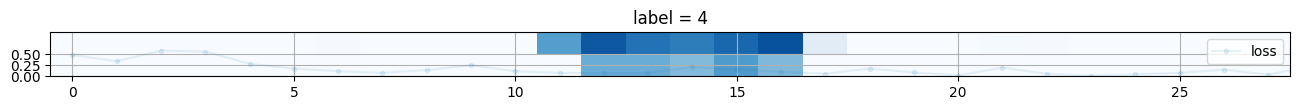

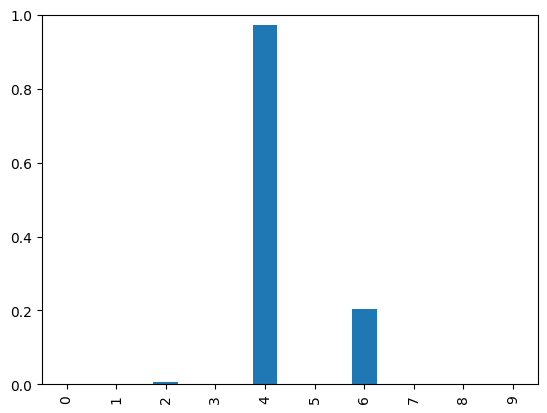

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

class FMnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=0)
        pass

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0

        # image data, normalised from 0-255 to 0-1
        image_values = torch.cuda.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

        # return label, image data tensor and target tensor
        return label, image_values, target

    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass

    pass

fmnist_dataset = FMnistDataset('mount/MyDrive/Colab Notebooks/fashion-mnist_train.csv')
#fmnist_dataset.plot_image(9)

class Classifier(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            # expand 1 to 10 filters
            nn.Conv2d(1, 30, kernel_size=5, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(30),

            # 10 filters to 10 filters
            nn.Conv2d(30, 40, kernel_size=3, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(40),

            View(1000),
            nn.Linear(1000, 10),
            nn.Sigmoid()
        )

        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters())

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass


    def forward(self, inputs):
        # simply run model
        return self.model(inputs)


    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass

    pass

C = Classifier()
C.to(device)
# train network on MNIST data set

epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in fmnist_dataset:
        C.train(image_data_tensor.view(1, 1, 28, 28), target_tensor)
        pass
    pass

C.plot_progress()
fmnist_test_dataset = FMnistDataset('mount/MyDrive/Colab Notebooks/fashion-mnist_test.csv')
record = 19

# plot image and correct label
fmnist_test_dataset.plot_image(record)
image_data = fmnist_test_dataset[record][1]

# query from trained network
output = C.forward(image_data.view(1,1,28,28))

# plot output tensor
pandas.DataFrame(output.detach().cpu().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

score = 0
items = 0

for label, image_data_tensor, target_tensor in fmnist_test_dataset:
    answer = C.forward(image_data_tensor.view(1,1,28,28)).detach().cpu().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1

    pass

print(score, items, score/items)